In [1]:
import os
import importlib
from pathlib import Path

Path().cwd()

PosixPath('/Users/davidspector/Home/Stanford/QuantUS Projects/PyQuantUS/CLI-Demos')

In [2]:
os.chdir(Path().cwd().parent)

In [3]:
Path().cwd()

PosixPath('/Users/davidspector/Home/Stanford/QuantUS Projects/PyQuantUS')

In [4]:
import pyquantus.parse.transforms
import pyquantus.parse.objects

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import hilbert
from typing import Tuple

In [7]:
scanPath = Path('/Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Verasonics RF/QUS_migr_1.mat')
parampath = Path('/Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Verasonics RF/param.mat')

In [8]:
scanFile = loadmat(scanPath)
paramFile = loadmat(parampath)

In [85]:
txBand = paramFile['SeqParam']['Trans'][0][0][0][0][5][0] # MHz
txFreq = scanFile['param']['TWFrequency'][0][0][0][0] # MHz
frameRate = scanFile['param']['Bmode'][0][0][0][0][3][0][0]
focus = scanFile['param']['Bmode'][0][0][0][0][1][0][0]*10 # cm
samplingFreq = scanFile['param']['fs'][0][0][0][0] # Hz
depth = scanFile['param']['TransRadiusmm'][0][0][0][0]*10 # cm
speedOfSound = scanFile['param']['c'][0][0][0][0] # m/s

theta = scanFile['param']['theta'][0][0][0]
radii = scanFile['param']['r'][0][0][0]
endDepth = max(radii)*100 # cm (GUESS)
startDepth = min(radii)*100 # cm (GUESS)
scanWidth = np.rad2deg(abs(max(theta) - min(theta)))
tilt=0

/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_2800/778712973.py:4: RuntimeWarning: overflow encountered in scalar multiply
  focus = scanFile['param']['Bmode'][0][0][0][0][1][0][0]*10 # cm


In [154]:
rfData = scanFile['RFmig']
bmode = np.zeros(rfData.shape)
for i in range(rfData.shape[2]):
    bmode[:,:,i] = 20*np.log10(abs(hilbert(rfData[:,:,i], axis=1)))

In [155]:
clipFact = 0.95; dynRange = 60

clippedMax = clipFact*np.amax(bmode)
bmode = np.clip(bmode, clippedMax-dynRange, clippedMax)
bmode -= np.amin(bmode)
bmode *= (255/np.amax(bmode))

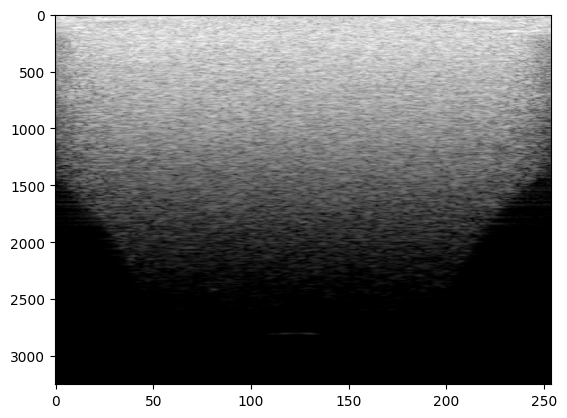

In [156]:
plt.imshow(bmode[:,:,0], cmap='gray', aspect='auto')

In [157]:
from pyquantus.parse.transforms import scanConvert

scBmodeStruct, hCm, wCm = scanConvert(bmode[:,:,10], scanWidth, tilt, startDepth, endDepth)

Depth (cm): 24.129580000000004


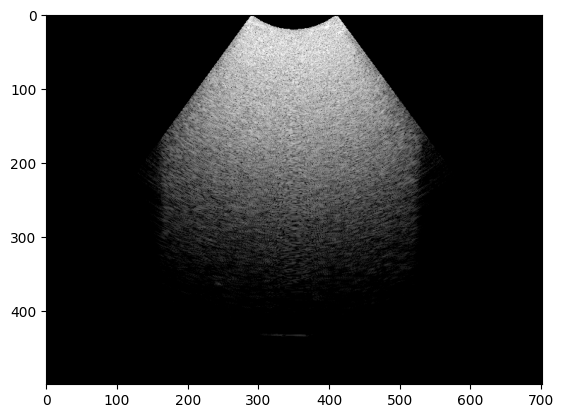

In [158]:
plt.imshow(scBmodeStruct.scArr, cmap='gray', aspect='auto')
print("Depth (cm):", endDepth)

In [76]:
theta = scanFile['param']['theta'][0][0][0]
radii = scanFile['param']['r'][0][0][0]

array([0.041219 , 0.0412806, 0.0413422, ..., 0.2411726, 0.2412342,
       0.2412958])

In [83]:
np.rad2deg(abs(max(theta) - min(theta)))

np.float64(74.65492125984278)

In [ ]:
desiredHeight = 500


In [ ]:
importlib.reload(pyquantus.parse.objects)
from pyquantus.parse.objects import DataOutputStruct, InfoStruct

def readFileInfo(scanPath: Path, paramPath: Path) -> Tuple[InfoStruct, float, np.ndarray, np.ndarray]:
    scanFile = loadmat(scanPath)
    paramFile = loadmat(paramPath)
    
    txBand = paramFile['SeqParam']['Trans'][0][0][0][0][5][0] # MHz
    txFreq = scanFile['param']['TWFrequency'][0][0][0][0] # MHz
    frameRate = scanFile['param']['Bmode'][0][0][0][0][3][0][0]
    focus = scanFile['param']['Bmode'][0][0][0][0][1][0][0]*10 # cm
    samplingFreq = scanFile['param']['fs'][0][0][0][0] # Hz
    depth = scanFile['param']['TransRadiusmm'][0][0][0][0]*10 # cm
    speedOfSound = scanFile['param']['c'][0][0][0][0] # m/s
    
    info = InfoStruct()
    info.minFrequency = txBand[0]*1e6
    info.maxFrequency = txBand[1]*1e6
    info.lowBandFreq = txBand[0]*1e6
    info.upBandFreq = txBand[1]*1e6
    info.centerFrequency = txFreq*1e6
    info.depth = depth
    info.samplingFrequency = samplingFreq
    info.clipFact = 1
    info.dynRange = 40
    
    return info, frameRate

def readFileImg(scanFile: dict, info: InfoStruct):
    
    